## Accessing Deltares global flood data on Azure

[Deltares](https://www.deltares.nl/en/) has produced a series of global inundation maps of flood depth using a geographic information systems (GIS)-based inundation model that takes into account water level attenuation and is forced by sea level. Multiple datasets were created using various digital elevation models (DEMs) at multiple resolutions under two different sea level rise (SLR) conditions: current (2018) and 2050. 

This notebook provides an example of accessing global flood data from blob storage on Azure.

This dataset is stored in the West Europe Azure region, so this notebook will run most efficiently on Azure compute located in the same region. If you are using this data for environmental science applications, consider applying for an AI for Earth grant to support your compute requirements.

Complete documentation for this dataset is available at https://aka.ms/ai4edata-deltares-gfm.

### Environment setup

In [1]:
import math
import warnings

warnings.simplefilter("ignore")

import fsspec
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

# Not used directly, but needs to be installed to read NetCDF files with xarray
import h5py
import h5netcdf

from dask.distributed import Client

### Create a local Dask cluster

Enable parallel reads and processing of data using Dask and xarray.

In [2]:
client = Client(processes=False)
print(f"/proxy/{client.scheduler_info()['services']['dashboard']}/status")

/proxy/8787/status


### File access

The entire dataset is made up of several dozen individual netCDF files, each representing an entire global inundation map, but derived from either a diferent source DEM, sea level rise condition, or return period. Return periods are occurence probabilities for floods of a particular magnitude, often referred to as, for example, "a 100 year flood".

To start, we'll load and plot the inundation data produced from the 90m NASADEM at a 100 year return period for 2050 sea level rise conditions. 

In [3]:
def make_url(year):
    root = (
        "https://deltaresfloodssa.blob.core.windows.net/floods/v2021.06"
    )
    dem_source = "NASADEM"
    return_period = "0100"
    path = f"{root}/global/{dem_source}/90m"
    file_name = f"GFM_global_{dem_source}90m_{year}slr_rp{return_period}_masked.nc"

    return f"{path}/{file_name}"


with fsspec.open(make_url(2050)) as f:
    ds = xr.open_dataset(f, chunks={"lat": 5000, "lon": 5000})

print(ds)

<xarray.Dataset>
Dimensions:     (lat: 216000, lon: 432000, time: 1)
Coordinates:
  * time        (time) datetime64[ns] 2010-01-01
  * lat         (lat) float64 -90.0 -90.0 -90.0 -90.0 ... 90.0 90.0 90.0 90.0
  * lon         (lon) float64 -180.0 -180.0 -180.0 -180.0 ... 180.0 180.0 180.0
Data variables:
    projection  |S1 ...
    inun        (time, lat, lon) float32 dask.array<chunksize=(1, 5000, 5000), meta=np.ndarray>
Attributes:
    source:       Global Tide and Surge Model v3.0 - ERA5
    institution:  Deltares
    title:        GFM - NASA DEM 90m - 2050 slr - 0100-year return level
    references:   https://www.deltares.nl/en/
    Conventions:  CF-1.6
    project:      Microsoft Planetary Computer - Global Flood Maps
    config_file:  /mnt/globalRuns/watermask_post_NASA90m_rest/run_rp0100_slr2...


### Define an area of interest

The data is 90m at a global scale, but most relevant in coastal areas. Let's zoom in a on a flood-prone region of Myanmar by defining a bounding box and clipping our xarray dataset.

In [4]:
from shapely.geometry import shape

myanmar_geojson = {
    "type": "Polygon",
    "coordinates": [
        [
            [93.9385986328125, 15.617746547613212],
            [96.96533203125, 15.617746547613212],
            [96.96533203125, 18.37016593904468],
            [93.9385986328125, 18.37016593904468],
            [93.9385986328125, 15.617746547613212],
        ]
    ],
}

poly = shape(myanmar_geojson)
minx, miny, maxx, maxy = poly.bounds
print("AoI bounds:", poly.bounds)

AoI bounds: (93.9385986328125, 15.617746547613212, 96.96533203125, 18.37016593904468)


In [5]:
ds_myanmar = ds.sel(lat=slice(miny, maxy), lon=slice(minx, maxx))
print(ds_myanmar)

<xarray.Dataset>
Dimensions:     (lat: 3303, lon: 3632, time: 1)
Coordinates:
  * time        (time) datetime64[ns] 2010-01-01
  * lat         (lat) float64 15.62 15.62 15.62 15.62 ... 18.37 18.37 18.37
  * lon         (lon) float64 93.94 93.94 93.94 93.94 ... 96.96 96.96 96.96
Data variables:
    projection  |S1 ...
    inun        (time, lat, lon) float32 dask.array<chunksize=(1, 3258, 1273), meta=np.ndarray>
Attributes:
    source:       Global Tide and Surge Model v3.0 - ERA5
    institution:  Deltares
    title:        GFM - NASA DEM 90m - 2050 slr - 0100-year return level
    references:   https://www.deltares.nl/en/
    Conventions:  CF-1.6
    project:      Microsoft Planetary Computer - Global Flood Maps
    config_file:  /mnt/globalRuns/watermask_post_NASA90m_rest/run_rp0100_slr2...


### Distribution of inundation amounts

For areas with greater than zero inundation, let's bin the data in 1m increments and see how it's distributed. Counting by 90m pixels is a rough estimate of actual area.

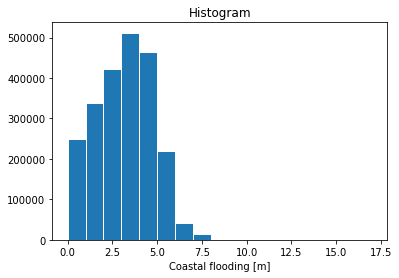

In [6]:
# Select only flooded area
flooded = ds_myanmar.where(ds_myanmar.inun > 0).isel(time=0).compute()

num_bins = math.ceil(flooded.inun.max().values)
flooded.inun.plot.hist(bins=range(0, num_bins), edgecolor="w")
plt.show()

### Plot the layer

We can also look at the geographic distribution of inundation. We'll add an Esri imagery basemap for some context in our plot.

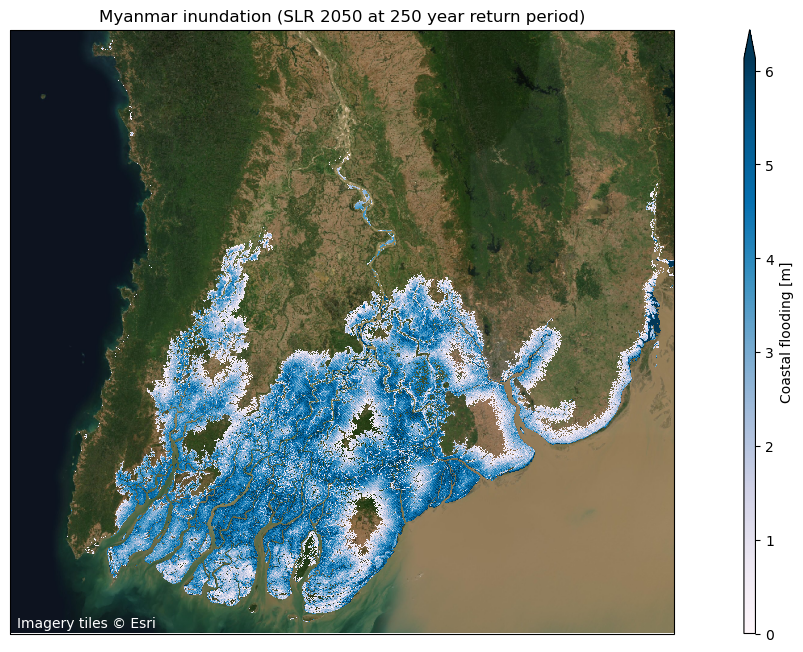

In [7]:
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt

fig = plt.figure(figsize=(18, 8), dpi=100)
ax = plt.axes(projection=ccrs.PlateCarree())

ax.set_extent([minx, maxx, miny, maxy])
flooded.inun.plot(
    ax=ax,
    transform=ccrs.PlateCarree(),
    cmap="PuBu",
    cbar_kwargs={"aspect": 50},
    robust=True,
    vmin=0
)

ax.set_title("Myanmar inundation (SLR 2050 at 250 year return period)")

# Add an esri image background with attribution
url = "https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}"
image = cimgt.GoogleTiles(url=url)
ax.add_image(image, 10)
plt.text(0.01, 0.01, "Imagery tiles © Esri", transform=ax.transAxes, color="w")
plt.show()

### Working with two sea level rise conditions

We've been looking at the 2050 sea level rise conditions. Let's compare with the current SLR conditions under the same DEM, resolution, and return period.

First we'll read in the other dataset and concatenate to a single xarray dataset.

In [8]:
# Open the 2018 dataset for the same DEM, resolution, and return period
with fsspec.open(make_url(2018)) as f:
    ds_2018 = xr.open_dataset(f, chunks={"lat": 5000, "lon": 5000})

# Clip to our same area of interest
ds_2018_myanmar = ds_2018.sel(lat=slice(miny, maxy), lon=slice(minx, maxx))

# Concat the two datasets along the time dimention
mds = xr.concat([ds_2018_myanmar, ds_myanmar], dim="time")

# Time coordinates are not set in the data files. Set them correctly to allow selecting by label.
mds = mds.assign_coords(
    time=np.array([np.datetime64("2018-01-01"), np.datetime64("2050-01-01")])
)
print(mds)

<xarray.Dataset>
Dimensions:     (lat: 3303, lon: 3632, time: 2)
Coordinates:
  * time        (time) datetime64[ns] 2018-01-01 2050-01-01
  * lat         (lat) float64 15.62 15.62 15.62 15.62 ... 18.37 18.37 18.37
  * lon         (lon) float64 93.94 93.94 93.94 93.94 ... 96.96 96.96 96.96
Data variables:
    projection  (time) |S1 b'' b''
    inun        (time, lat, lon) float32 dask.array<chunksize=(1, 3258, 1273), meta=np.ndarray>
Attributes:
    source:       Global Tide and Surge Model v3.0 - ERA5
    institution:  Deltares
    title:        GFM - NASA DEM 90m - 2018 slr - 0100-year return level
    references:   https://www.deltares.nl/en/
    Conventions:  CF-1.6
    project:      Microsoft Planetary Computer - Global Flood Maps
    config_file:  /mnt/globalRuns/watermask_post_NASA/run_rp0100_slr2018/coas...


#### Plot the two layers

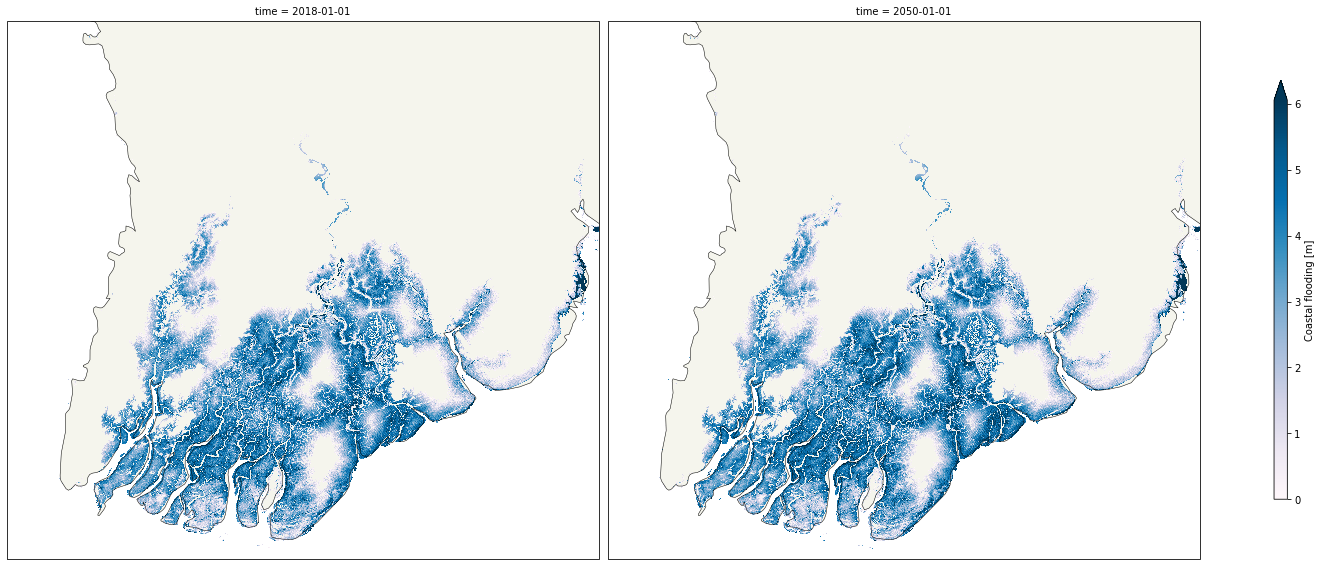

In [9]:
import cartopy.feature as cfeature
import cartopy.crs as ccrs

flooded = mds.where(mds.inun > 0).load()

prj = ccrs.PlateCarree()

p = flooded.inun.plot(
    col="time",
    col_wrap=None,
    transform=prj,
    subplot_kws={"projection": prj},
    cmap="PuBu",
    size=10,
    cbar_kwargs={"aspect": 30, "shrink": 0.6},
    robust=True,
    vmin=0
)

for ax in p.axes.flat:
    ax.coastlines(linewidth=0.5)
    ax.set_extent([minx, maxx, miny, maxy])
    ax.add_feature(cfeature.LAND, zorder=0, linewidth=0.5, facecolor="#f5f5ed")

plt.draw()

#### Compare the distribution of inundation depth by area

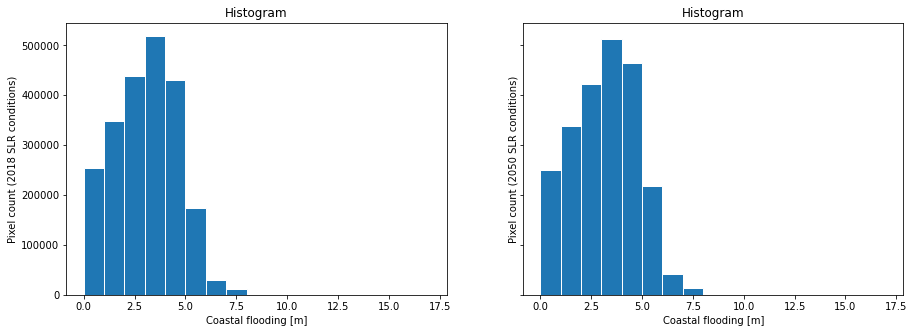

In [10]:
fig, axes = plt.subplots(ncols=2, figsize=(15, 5), sharey=True, sharex=True)

for i in range(2):
    num_bins = math.ceil(flooded.inun.max().values)
    year = str(flooded.isel(time=i).time.values)[:4]
    axes[i].set_ylabel(f"Pixel count ({year} SLR conditions)")
    flooded.inun.isel(time=i).plot.hist(
        ax=axes[i], edgecolor="white", bins=range(0, num_bins)
    )

plt.show()

### Plot areas of increased inundation under 2050 sea level rise conditions

It was a bit hard to see predicted changes in inundation in the side-by-side map plots, but the histograms showed a definite increase in the higher bins. Let's calculate the difference and plot just the increase.

In [11]:
diff = mds["inun"].diff("time")
diff = diff.where(diff > 0)

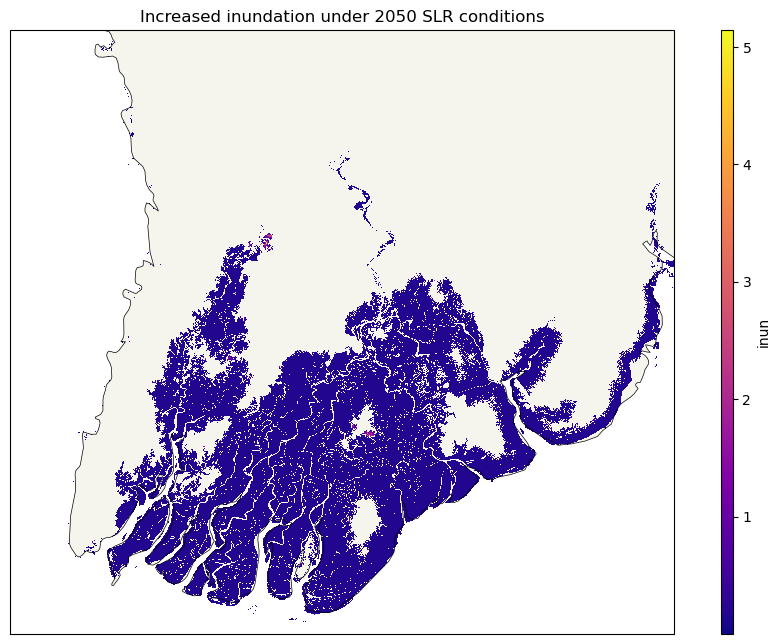

In [12]:
fig, axis = plt.subplots(
    subplot_kw=dict(projection=ccrs.PlateCarree()), figsize=(12, 8), dpi=100
)

diff.plot(
    ax=axis, transform=ccrs.PlateCarree(), cmap="plasma", cbar_kwargs={"aspect": 50}
)

plt.title("Increased inundation under 2050 SLR conditions")
axis.coastlines(linewidth=0.5)
axis.set_extent([minx, maxx, miny, maxy])
axis.add_feature(cfeature.LAND, zorder=0, linewidth=0, facecolor="#f5f5ed")

plt.draw()